In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, QuantileTransformer
import torch
import torch.nn as nn
import sys, os
sys.path.append(os.path.abspath("../src"))
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from node.lib.odst import ODST

In [7]:
# Load datasets
red = pd.read_csv("../data/wine+quality/winequality-red.csv", sep=';')
white = pd.read_csv("../data/wine+quality/winequality-white.csv", sep=';')

# Add 'type' feature
red['type'] = 'red'
white['type'] = 'white'

# Combine datasets
df = pd.concat([red, white], ignore_index=True)

# One-hot encode 'type'
df = pd.get_dummies(df, columns=['type'], drop_first=True)

# Separate features and target
X = df.drop('quality', axis=1)
y = df['quality']

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Apply quantile transformation to features
qt = QuantileTransformer(output_distribution='normal')
X_transformed = qt.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [10]:
input_dim = X_train.shape[1]
num_classes = len(set(y_train))

model = nn.Sequential(
    ODST(
        in_features=input_dim,
        num_trees=64,
        depth=6,
        tree_dim=3,
        flatten_output=True
    ),
    nn.Linear(64 * 3, num_classes)
)

In [11]:
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train()
for epoch in range(10):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

/Users/ozgun/Desktop/cs454/CS454-Project/src/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


Epoch 1, Loss: 1.5628
Epoch 2, Loss: 1.2698
Epoch 3, Loss: 1.4403
Epoch 4, Loss: 1.0842
Epoch 5, Loss: 1.0987
Epoch 6, Loss: 1.1092
Epoch 7, Loss: 1.2033
Epoch 8, Loss: 1.0426
Epoch 9, Loss: 1.0728
Epoch 10, Loss: 1.0423


Accuracy: 0.5400
Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        43
           5       0.59      0.57      0.58       428
           6       0.52      0.69      0.60       567
           7       0.49      0.29      0.37       216
           8       0.00      0.00      0.00        39
           9       0.00      0.00      0.00         1

    accuracy                           0.54      1300
   macro avg       0.23      0.22      0.22      1300
weighted avg       0.50      0.54      0.51      1300



/opt/anaconda3/envs/sago/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/sago/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/sago/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


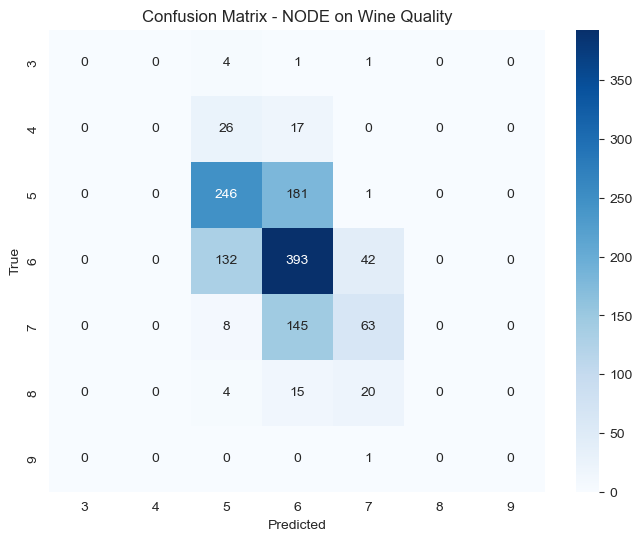

In [12]:
# Prepare test data
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_pred_probs = model(X_test_tensor)
    y_pred = torch.argmax(y_pred_probs, dim=1).numpy()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_.astype(str)))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - NODE on Wine Quality")
plt.show()